In [5]:
%matplotlib inline
import sys
import pandas as pd
import numpy as np
import cv2
import scipy

from PIL import Image

import math
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.externals import joblib
import time

import pytesseract

In [6]:
# Stroke width transform - microsoft paper
def stroke_width_transform(filename):
#     print("**** filename", filename)
    img = cv2.imread(filename,0)
#     print("image", image)
    
    # initialise with infinite intensity at each pixel
    swt_img = np.empty(img.shape)
    swt_img[:]=np.infty

    edges = cv2.Canny(img,200,250)  # find out the edges using canny detector

    grad_x = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=-1) # scharr filter
    grad_y = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=-1)
    direction_y = grad_x/np.sqrt(grad_x**2 + grad_y**2) # normalised step
    direction_x = grad_y/np.sqrt(grad_x**2 + grad_y**2)
    
#     user = input('bright text on dark background? Press "y" for yes and any other key for no.')
#     if user.lower() != 'y':
#         direction_y = -direction_y
#         direction_x = -direction_x


    vectors = []
    for y in range(img.shape[1]):
        for x in range(img.shape[0]):
            if edges[x,y]>0:
                vector=[]
                vector.append((x,y))
                n=0
                prev_x,prev_y = x,y
                while True:
                    n+=1
                    if np.isnan(direction_x[x,y]) and np.isnan(direction_y[x,y]):
                        break
                    new_x,new_y = math.floor(x + direction_x[x,y]*n), math.floor(y + direction_y[x,y]*n)
                    if new_x!=prev_x or new_y!=prev_y:    
                        try:
                            if edges[new_x,new_y]>0:
                                vector.append((new_x,new_y))
                                if np.arccos(-direction_x[new_x,new_y]*direction_x[x,y] - direction_y[new_x,new_y]*direction_y[x,y])<np.pi/2.0:
                                    for a,b in vector:
                                        swt_img[a,b]=min(np.linalg.norm((new_x-x,new_y-y)),swt_img[a,b])
                                    vectors.append(vector)
                                break
                            else:
                                vector.append((new_x,new_y))
                        except IndexError:
                            break
                        prev_x,prev_y = new_x,new_y
    for elem in vectors:
        median = np.median([swt_img[a,b] for a,b in elem])
        for a,b in elem:
            swt_img[a,b] = min(swt_img[a,b],median)
        
    return swt_img

# Connected component labelling for stroke width transform
def connected_components(swt_im):
    con_img = np.zeros(swt_im.shape)
    con_list={}
    rows = swt_im.shape[0]
    cols = swt_im.shape[1]
    n=1
    for x in range(rows):
        for y in range(cols):
            if swt_im[x,y]<np.infty and swt_im[x,y]>0:
                neigh = [(x,y-1),(x-1,y)]
                neighbours=[]
                for elem in neigh:
                    if -1 not in elem:
                        neighbours.append(elem)
                l=[]
                for i,j in neighbours:
                    try:
                        ratio = swt_im[x,y]/swt_im[i,j]
                    except IndexError:
                        continue
                    if ratio<2.5 and 1/ratio<2.5:
                        if con_img[i,j]>0 and con_img[i,j] not in l:
                            l.append(con_img[i,j])

                if len(l)<1:
                    con_img[x,y]=n
                    n+=1
                elif len(l)>1:
                    con_img[x,y] = min(l)
                    if min(l) in con_list:
                        con_list[min(l)].extend(l)
                    else:
                        con_list[min(l)]=l
                else:
                    con_img[x,y] = min(l)
                   
    for key,value in con_list.items():
        for val in value:
            con_img[con_img==val] = key
    return con_img


/home/void/Projects/OCR/Text-detection-in-natural-scene-images/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/home/void/Projects/OCR/Text-detection-in-natural-scene-images/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/home/void/Projects/OCR/Text-detection-in-natural-scene-images/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in double_scalars
/home/void/Projects/OCR/Text-detection-in-natural-scene-images/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/home/void/Projects/OCR/Text-detection-in-natural-scene-images/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataC

He looked at me

as if ihaudtoid him
Iwas going to built
aspat rocket


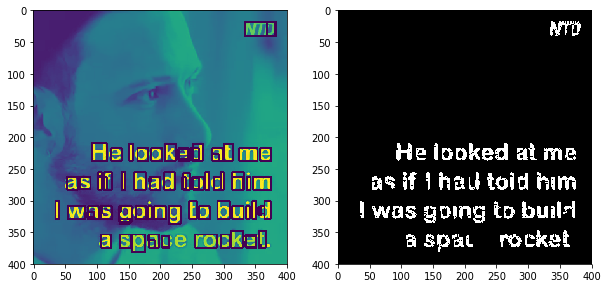

In [9]:
image = '../Text-detection-in-natural-scene-images-dataset/text or no text dataset/test images/25541.jpg'
img = cv2.imread(image, 0)

swt = stroke_width_transform(image)
cc = connected_components(swt)

con_img = {}
for label in np.unique(cc[cc>0]):
    image = np.zeros(cc.shape)
    indices = np.where(cc==label)
    image[indices] = 1
    con_img[label] = image
# print(con_img)

tot1=0
i=1
mask = {}
i=1
model = load_model('../Text-detection-in-natural-scene-images/my_model_base_2.h5')
loaded_scaler = joblib.load('../Text-detection-in-natural-scene-images/my_scaler_base_2.pkl')
for elem in con_img.keys():
    x,y,w,h = cv2.boundingRect(np.uint8(con_img[elem]))
    imng = img[y:y+h,x:x+w]
    imng =  scipy.misc.imresize(imng,(32,32)).ravel().reshape(1,1024)
    imng = loaded_scaler.transform(imng)
    imng = imng.reshape((1,32,32,1))
#     print(elem,np.around(classifier.predict(imng)))
    if np.around(model.predict(imng)) == 1.0:
        #print('yuhoo')
        tot1+=con_img[elem]
#         mask[i]=con_img[elem]
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        i+=1
        
        
im = Image.fromarray((tot1 * 255).astype(np.uint8))
im.save("../Text-detection-in-natural-scene-images-dataset/text or no text dataset/test images/binarized.jpg")

plt.figure(figsize=[10,10])
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(tot1,'gray')

# print("cc_image", cc_img)
# plt.imshow(cc_img, 'gray')
# cc_img = cv2.bitwise_not(cc_img)
# plt.imshow(cc_img, 'gray')

final_image = cv2.imread("../Text-detection-in-natural-scene-images-dataset/text or no text dataset/test images/binarized.jpg")
final_image = cv2.bitwise_not(final_image)
print(pytesseract.image_to_string(final_image))

In [4]:


# finding letters
# def find_letters(con,swt):
#     width = {}
#     height = {}
#     labels = np.unique(con[con>0])
#     for label in labels:
#         l = np.where(con==label)
#         width[label],height[label] = max(l[0])-min(l[0]),max(l[1])-min(l[1])
        
#         if len(con[con==label])<10:
#             con[con==label]=255
            
#         if width[label]<8 or height[label]<8:
#             con[con==label]=255
    
#         if width[label]/height[label]<0.1 or width[label]/height[label]>10:
#             con[con==label]=255
    
#         if width[label]/con.shape[1]>0.4 or height[label]/con.shape[0]>0.4:
#             con[con==label]=255
        
#         diameter = np.sqrt(width[label]**2 + height[label]**2)
#         med_stroke = np.median(swt[l])
    
#         if diameter/med_stroke>20:
#             con[con==label]=255
            
#         if width[label]<10 or height[label]>300:
#             con[con==label]=255
            
#         mu = np.mean(swt[l])
#         mean_var_stroke = np.mean((swt[l]-mu)**2)
#         if mean_var_stroke>20:
#             con[con==label]=255

   # return con,width,height

In [1]:
# plt.imshow(swt)

In [2]:
# cc_img = connected_components(swt)

In [3]:
# plt.imshow(cc_img)

In [4]:
# plt.imshow(find_letters(cc_img,swt)[0],'gray')

In [5]:
# final_image,wid,hghts = find_letters(connected_components(swt),swt)
# plt.figure(figsize=[20,10])
# plt.subplot(1,3,1)
# plt.imshow(cv2.imread(image,0))
# plt.subplot(1,3,1)
# plt.imshow(swt)
# plt.subplot(1,3,2)
# plt.imshow(cc_img,'gray')